In [1042]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

from sklearn import linear_model
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

import seaborn as sns
import missingno as msno

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
import pprint
from sklearn.metrics import precision_recall_fscore_support

Just imported every classification tool you could ever need, and now I'm loading up the data, and turning our target labels into numeric, rather than string data (essential for doing the Random Forest model later on)

In [1043]:
fulldf= pd.read_csv("C:/Users/Izzy/Desktop/213R/project1.csv")
df= pd.read_csv("C:/Users/Izzy/Desktop/213R/project1.csv")

In [1044]:
df['contnum'] = df['cont'].copy()
df['contnum'].replace('Asia', 1, inplace=True)
df['contnum'].replace('Africa', 2, inplace=True)
df['contnum'].replace('Europe', 3, inplace=True)
df['contnum'].replace('North America', 4, inplace=True)
df['contnum'].replace('Oceania', 5, inplace=True)
df['contnum'].replace('South America', 6, inplace=True)

## Data Cleaning

With the data loaded in, we found that it wasn't quite ready to go.  Symbols had carried over from the csv, and so we had to eliminate those before we could perform basic functions and transformations on the features.

In [1045]:
df=df.replace(',', '' , regex=True)

In [1046]:
df=df.replace('%', '' , regex=True)

In [1047]:
df['GDP_PPP_percapita']=df['GDP_PPP_percapita'].str.replace('$', '')

In [1048]:
df.head()

,cont,name,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,...,LifeExpectancy,TotalFertilityRate,AdultObesityRate,HealthExpend,ChildUnderwt,ChildUnderwtYr,GDP PPP,GDP_PPP_percapita,Percent Urban,contnum
0,Asia,Afghanistan,31108077,652230,0,2.25,39.05,14.35,-2.16,460.0,...,50.11,5.54,2.2,7.6,32.9,2004.0,34290000000,1100,23.50,1
1,Europe,Albania,3011405,28748,362,0.29,12.57,6.36,-3.32,27.0,...,77.77,1.49,21.3,6.6,6.3,2009.0,26540000000,8200,52,3
2,Africa,Algeria,38087812,2381741,998,1.90,24.25,4.31,-0.93,97.0,...,76.18,2.78,16.0,4.2,3.7,2005.0,277400000000,7600,73,2
3,Oceania,American Samoa,54719,199,116,-0.40,22.84,4.62,-22.17,NaN,...,74.68,3.04,74.6,NaN,NaN,NaN,575300000,8000,93,5
4,Europe,Andorra,85293,468,0,0.22,8.88,6.67,0.00,NaN,...,82.58,1.37,25.2,7.5,NaN,NaN,3163000000,37200,88,3


Looking at the data printed above, we can see that those symbols have been removed.  A few more steps before we're ready to go-
First we convert all of the numeric features to floats so that they will be recognized as numeric.  

Next, we do some feature engineering, creating a population density feature and coastline to area squared ratio using existing features.

In [1049]:
df.loc[:, 'Pop2013':'Percent Urban']= df.loc[:, 'Pop2013':'Percent Urban'].astype(float)

In [1050]:
df['PopDens']= df['Pop2013']/df['Area_sqkm']

In [1051]:
df['Coast_Area_Ratio'] = df['coastline_km'] / df['Area_sqkm']

In [1052]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 23 columns):
cont                     223 non-null object
name                     223 non-null object
Pop2013                  223 non-null float64
Area_sqkm                223 non-null float64
coastline_km             223 non-null float64
PopGrowthRate            223 non-null float64
BirthRate                223 non-null float64
DeathRate                223 non-null float64
NetMigrationRate         220 non-null float64
MaternalMortalityRate    183 non-null float64
IMR                      222 non-null float64
LifeExpectancy           222 non-null float64
TotalFertilityRate       222 non-null float64
AdultObesityRate         190 non-null float64
HealthExpend             190 non-null float64
ChildUnderwt             132 non-null float64
ChildUnderwtYr           132 non-null float64
GDP PPP                  222 non-null float64
GDP_PPP_percapita        223 non-null float64
Percent Urban          

The type of data looks good, so now we'll move to imputing values for missing data. 

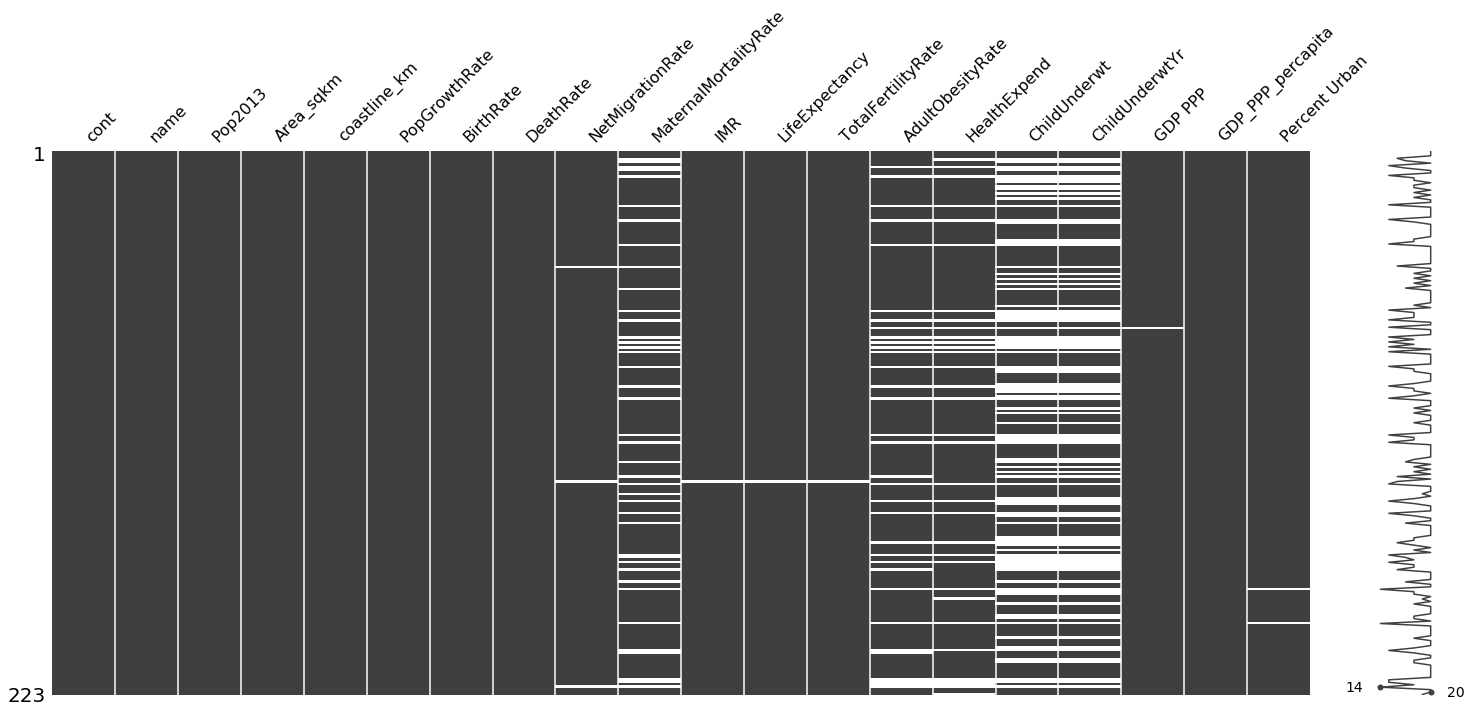

In [1053]:
msno.matrix(fulldf)

In [1054]:
df.isnull().sum()

cont                      0
name                      0
Pop2013                   0
Area_sqkm                 0
coastline_km              0
PopGrowthRate             0
BirthRate                 0
DeathRate                 0
NetMigrationRate          3
MaternalMortalityRate    40
IMR                       1
LifeExpectancy            1
TotalFertilityRate        1
AdultObesityRate         33
HealthExpend             33
ChildUnderwt             91
ChildUnderwtYr           91
GDP PPP                   1
GDP_PPP_percapita         0
Percent Urban             2
contnum                   0
PopDens                   0
Coast_Area_Ratio          0
dtype: int64

As we've seen above, we've got a few features with substantial missing data.  The measures for children underweight have so many observations missing that we decided to drop the feature alltogether. 

For the rest, we created a function to fill the missing observations with the median value of that variable. 

We tried to figure out a way to create a function that would fill missing data with the median value of that variable within the continent the country belongs to, but to no avail- though below our function you can see our attempt.

In [1055]:
df.drop(columns = 'ChildUnderwt', inplace=True)
df.drop(columns = 'ChildUnderwtYr', inplace=True)

In [1056]:
def mynafill(var):
    df[var].fillna((df[var].median()), inplace=True)
    
      
    #df[var] = df[var].groupby(df['cont']).fillna(df[var].groupby(df['cont']).mean())

In [1057]:
mynafill("MaternalMortalityRate")
mynafill("NetMigrationRate")
mynafill("IMR")
mynafill("LifeExpectancy")
mynafill("TotalFertilityRate")
mynafill("AdultObesityRate")
mynafill("HealthExpend")
mynafill("GDP PPP")
mynafill("Percent Urban")

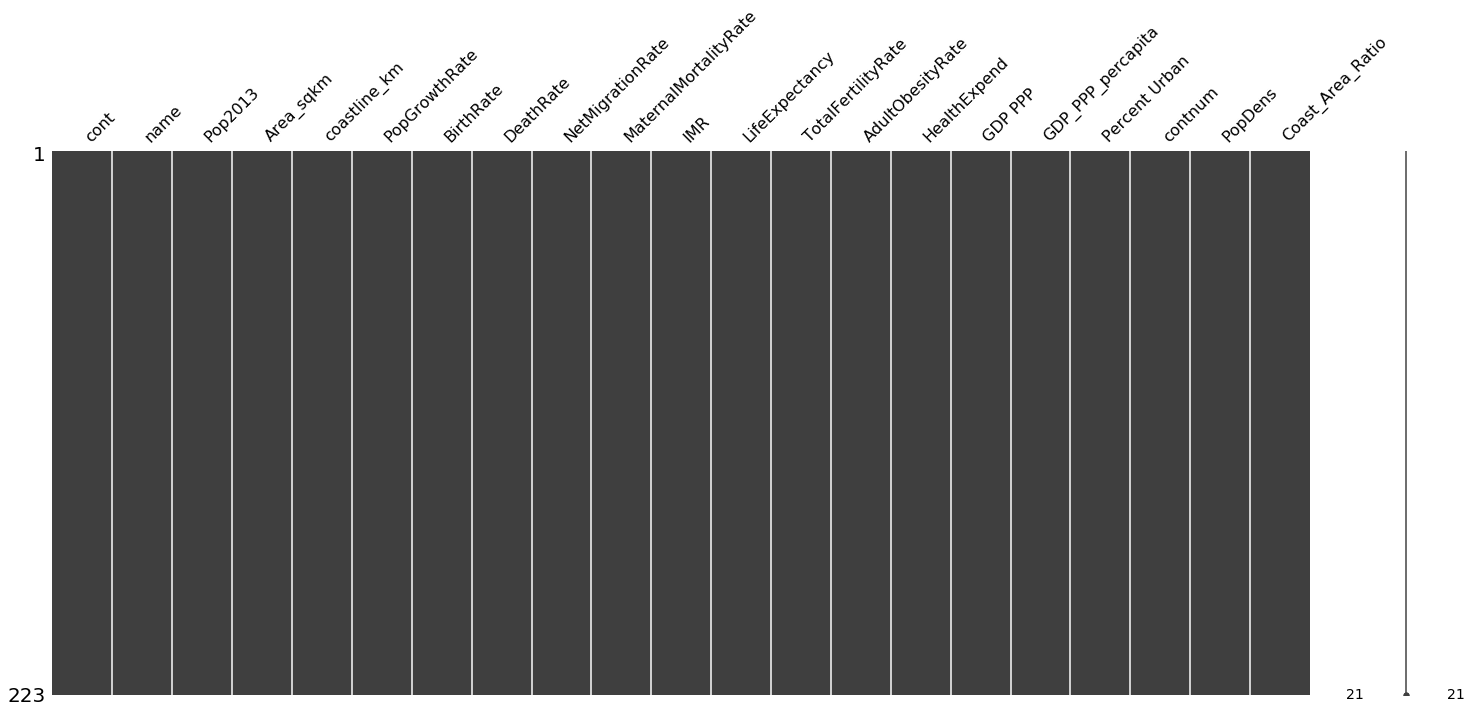

In [1058]:
msno.matrix(df)

## Modeling

With the cleaning all done, we pre now split the dataframe, separating our label and target columns from the features.  Afterwords, we check to make sure it all looks good.  

In [1059]:
Y=df['contnum']
cont=df['cont']
name=df['name']
X=df
X.drop(columns = 'cont', inplace=True)
X.drop(columns = 'contnum', inplace=True)
X.drop(columns = 'name', inplace=True)

In [1060]:
print(np.unique(Y))

[1 2 3 4 5 6]


In [1061]:
X.tail()

,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,IMR,LifeExpectancy,TotalFertilityRate,AdultObesityRate,HealthExpend,GDP PPP,GDP_PPP_percapita,Percent Urban,PopDens,Coast_Area_Ratio
218,2676740.0,5860.0,0.0,2.03,23.81,3.53,0.00,64.0,13.98,75.46,2.91,19.95,6.6,8.022000e+09,2900.0,74.3,456.781570,0.000000
219,538811.0,266000.0,1110.0,2.96,31.18,8.64,-0.06,66.0,57.50,61.90,4.15,19.95,6.6,9.065000e+08,2500.0,82.0,2.025605,0.004173
220,25408288.0,527968.0,1906.0,2.50,31.63,6.64,0.00,200.0,51.93,64.47,4.27,14.50,5.2,6.006000e+10,2300.0,32.3,48.124674,0.003610
221,14222233.0,752618.0,0.0,2.89,42.79,13.17,-0.75,440.0,68.58,51.51,5.81,3.60,5.9,2.436000e+10,1700.0,39.2,18.897014,0.000000
222,13182908.0,390757.0,0.0,4.38,32.41,11.40,22.76,570.0,27.25,53.86,3.58,7.00,6.6,7.366000e+09,600.0,38.6,33.736844,0.000000


## KNearestNeighbors Classifier

In [1062]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=18)
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7,], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]})
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_, average=None))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Train F1: [0.54545455 0.56896552 0.52631579 0.33333333 0.54545455 0.        ]
Test Classification Report:
             precision    recall  f1-score   support

          1       0.38      0.33      0.35         9
          2       0.33      0.38      0.35         8
          3       0.36      0.50      0.42         8
          4       0.50      0.17      0.25         6
          5       0.25      0.50      0.33         2
          6       0.00      0.00      0.00         1

avg / total       0.37      0.35      0.34        34

Train Accuracy: 0.5079365079365079	Test accuracy: 0.35294117647058826


C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Right out of the gate we can see that our knn model is not performing very well.  Even the train accuracy isn't very good, and the 35% accuracy on the testing data is abysmal. 

We wondered if the model would work better if we simplified the data a bit- turning a few of the continuous features into a score of relative advantage.  Below we do just that 

In [1063]:
X_score=X.copy()

In [1064]:
def quintiles(var):
    X_score[var+'q'] = pd.qcut(X_score[var] ,5, labels=[1,2,3,4,5]).astype(float)

In [1065]:
quintiles('IMR')
quintiles('HealthExpend')
quintiles('LifeExpectancy')
quintiles('GDP_PPP_percapita')

In [1066]:
X_score['IMRq']*=-1
X_score['advantage_score'] = X_score.loc[:, 'IMRq':'GDP_PPP_percapitaq'].sum(axis=1)

In [1067]:
X_score.drop(columns = 'IMR', inplace=True)
X_score.drop(columns = 'HealthExpend', inplace=True)
X_score.drop(columns = 'LifeExpectancy', inplace=True)
X_score.drop(columns = 'GDP_PPP_percapita', inplace=True)

In [1068]:
X_score.drop(columns = 'IMRq', inplace=True)
X_score.drop(columns = 'HealthExpendq', inplace=True)
X_score.drop(columns = 'LifeExpectancyq', inplace=True)
X_score.drop(columns = 'GDP_PPP_percapitaq', inplace=True)

In [1069]:
X_score.head()

,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,TotalFertilityRate,AdultObesityRate,GDP PPP,Percent Urban,PopDens,Coast_Area_Ratio,advantage_score
0,31108077.0,652230.0,0.0,2.25,39.05,14.35,-2.16,460.0,5.54,2.2,3.429000e+10,23.5,47.694950,0.000000,1.0
1,3011405.0,28748.0,362.0,0.29,12.57,6.36,-3.32,27.0,1.49,21.3,2.654000e+10,52.0,104.751809,0.012592,7.0
2,38087812.0,2381741.0,998.0,1.90,24.25,4.31,-0.93,97.0,2.78,16.0,2.774000e+11,73.0,15.991584,0.000419,3.0
3,54719.0,199.0,116.0,-0.40,22.84,4.62,-22.17,66.0,3.04,74.6,5.753000e+08,93.0,274.969849,0.582915,7.0
4,85293.0,468.0,0.0,0.22,8.88,6.67,0.00,66.0,1.37,25.2,3.163000e+09,88.0,182.250000,0.000000,13.0


In [1070]:
X_train, X_test, y_train, y_test = train_test_split(X_score, Y, test_size=0.15, random_state=18)
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7,], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]})
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_, average=None))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Train F1: [0.54545455 0.56896552 0.52631579 0.33333333 0.54545455 0.        ]
Test Classification Report:
             precision    recall  f1-score   support

          1       0.38      0.33      0.35         9
          2       0.33      0.38      0.35         8
          3       0.36      0.50      0.42         8
          4       0.50      0.17      0.25         6
          5       0.25      0.50      0.33         2
          6       0.00      0.00      0.00         1

avg / total       0.37      0.35      0.34        34

Train Accuracy: 0.5079365079365079	Test accuracy: 0.35294117647058826


C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Unfortunately, this feature engineering had no effect on the accuracy of our model. Instead, we turn to a new model.

## Random Forest Classifier

We decided to try our random forest model on two different sets of the data.  

The first model we feed the same dataframe as the last knn model- the one that includes the score of advantage.

For the second model, knowing that decision trees should theoretically work best on categorical data, we run the model on a dataset in which we have reduced all of our features into binned categorical quintiles.  

Immediately below we create that categorical data. 

In [1071]:
#X_cat is going to be our categorical dataset
X_cat=X.copy()

In [1072]:
def quintiles(var):
    X_cat[var+'q'] = pd.qcut(X_cat[var] ,5, labels=[1,2,3,4,5]).astype(float)

In [1073]:
quintiles('Pop2013')
quintiles('Area_sqkm')
quintiles('coastline_km')
quintiles('PopGrowthRate')
quintiles('BirthRate')
quintiles('DeathRate')
quintiles('NetMigrationRate')
quintiles('MaternalMortalityRate')
quintiles('TotalFertilityRate')
quintiles('AdultObesityRate')
quintiles('GDP PPP')
quintiles('Percent Urban')
quintiles('PopDens')
quintiles('Coast_Area_Ratio')
quintiles('IMR')
quintiles('HealthExpend')
quintiles('LifeExpectancy')
quintiles('GDP_PPP_percapita')

In [1074]:
X_cat.drop(columns = X_cat.loc[:, 'Pop2013':'Coast_Area_Ratio'], inplace=True)

In [1075]:
X_cat.head()

,Pop2013q,Area_sqkmq,coastline_kmq,PopGrowthRateq,BirthRateq,DeathRateq,NetMigrationRateq,MaternalMortalityRateq,TotalFertilityRateq,AdultObesityRateq,GDP PPPq,Percent Urbanq,PopDensq,Coast_Area_Ratioq,IMRq,HealthExpendq,LifeExpectancyq,GDP_PPP_percapitaq
0,5.0,5.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,1.0,3.0,1.0,2.0,1.0,5.0,4.0,1.0,1.0
1,2.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0
2,5.0,5.0,4.0,4.0,4.0,1.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,1.0,1.0,2.0,1.0,4.0,1.0,1.0,3.0,4.0,5.0,1.0,5.0,5.0,5.0,2.0,3.0,3.0,3.0
4,1.0,1.0,1.0,2.0,1.0,2.0,3.0,3.0,1.0,4.0,2.0,5.0,4.0,1.0,1.0,4.0,5.0,5.0


In [1076]:
X_train, X_test, y_train, y_test = train_test_split(X_score, Y, test_size=0.15, random_state=18)

n_estimators = [1000, 750, 500]
max_depth = [5, 10, 15]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            rf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(rf.oob_decision_function_ , 1), average='micro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
1000 15 balanced
1000 15 None
750 5 balanced
750 5 None
750 10 balanced
750 10 None
750 15 balanced
750 15 None
500 5 balanced
500 5 None
500 10 balanced
500 10 None
500 15 balanced
500 15 None


In [1077]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.06349206349206349
Best params: (750, 5, 'balanced')


In [1078]:
rf = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight=None)
rf.fit(X_train, y_train)
train_predictions5 = rf.predict(X_train)
print(classification_report(y_train, train_predictions5))

             precision    recall  f1-score   support

          1       0.89      0.98      0.93        43
          2       1.00      0.89      0.94        47
          3       0.95      1.00      0.98        40
          4       0.84      0.96      0.90        28
          5       1.00      0.89      0.94        19
          6       1.00      0.75      0.86        12

avg / total       0.94      0.94      0.94       189



In [1079]:
rf = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight=None)
rf.fit(X_train, y_train)
test_pred1 = rf.predict(X_test)
print(classification_report(y_test, test_pred1))

             precision    recall  f1-score   support

          1       0.78      0.78      0.78         9
          2       0.86      0.75      0.80         8
          3       0.89      1.00      0.94         8
          4       0.57      0.67      0.62         6
          5       1.00      1.00      1.00         2
          6       0.00      0.00      0.00         1

avg / total       0.78      0.79      0.78        34



C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1080]:
f1_score(y_train, train_predictions5, average = 'macro')

0.9257251026228827

In [1081]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Izzy\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

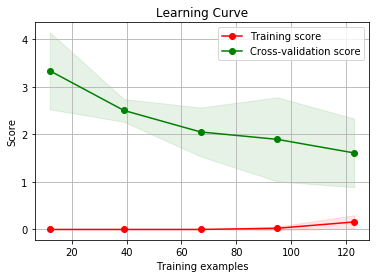

In [1082]:
plot_learning_curve(rf, "Learning Curve", X_train, y_train)

C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


<module 'matplotlib.pyplot' from 'C:\\Users\\Izzy\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

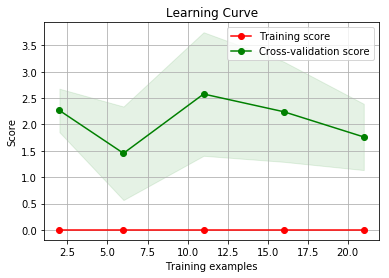

In [1083]:
plot_learning_curve(rf, "Learning Curve", X_test, y_test)

Alright, we've run our first model with the more normal data set, and from the looks of our accuracy as well as the MSE visualed above by our learning curve, it looks like we're doing pretty well.  

Now we'll see how the categorical version of the data runs in the model.

In [1084]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, Y, test_size=0.15, random_state=18)

n_estimators = [1000, 750, 500]
max_depth = [5, 10, 15]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            rf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(rf.oob_decision_function_ , 1), average='micro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
1000 15 balanced
1000 15 None
750 5 balanced
750 5 None
750 10 balanced
750 10 None
750 15 balanced
750 15 None
500 5 balanced
500 5 None
500 10 balanced
500 10 None
500 15 balanced
500 15 None


In [1085]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.06878306878306878
Best params: (1000, 5, 'balanced')


In [1086]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight=None)
rf.fit(X_train, y_train)
train_predictions5 = rf.predict(X_train)
print(classification_report(y_train, train_predictions5))

             precision    recall  f1-score   support

          1       0.77      0.95      0.85        43
          2       1.00      0.87      0.93        47
          3       0.83      1.00      0.91        40
          4       0.92      0.82      0.87        28
          5       1.00      0.79      0.88        19
          6       1.00      0.58      0.74        12

avg / total       0.90      0.88      0.88       189



In [1087]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight=None)
rf.fit(X_train, y_train)
test_pred1 = rf.predict(X_test)
print(classification_report(y_test, test_pred1))

             precision    recall  f1-score   support

          1       0.78      0.78      0.78         9
          2       0.86      0.75      0.80         8
          3       0.89      1.00      0.94         8
          4       0.50      0.67      0.57         6
          5       1.00      0.50      0.67         2
          6       0.00      0.00      0.00         1

avg / total       0.76      0.76      0.76        34



C:\Users\Izzy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1088]:
f1_score(y_train, train_predictions5, average = 'macro')

0.8636992220528787

Turns out the all categorical data set performed worse in the random forest model, despite our theoretical idea that it would be easier for the model to process and classify.  Who'd have thunk?

Considered going on to try the model after dropping area and coastline.  Haven't done it yet though, but still could.  